<a href="https://colab.research.google.com/github/kaidalisohaib/AICohortW24/blob/Sohaib/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python --version

Python 3.10.1


## Step 1: Import necessary libraries

In [3]:
import os
import time
import logging

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    average_precision_score, make_scorer, precision_score
)

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline


%matplotlib inline

sns.set_context("notebook")

sns.set_theme(style="ticks")

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## Step 2: Load the dataset

In [4]:
# input_file_path = "..\\data\\heart_disease_health_indicators_BRFSS2015.csv"
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

df.head()

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get non-numerical (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("All the columns:\n", all_columns)
print("Target column:\n", target_column)
print("Features columns:\n", all_features)
print("Numerical Columns:\n",numerical_cols)
print("Categorical Columns:\n",categorical_cols)


All the columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target column:
 HeartDiseaseorAttack
Features columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Numerical Columns:
 ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Categorical Columns:
 []


## Step 3: Data exploration

### 3.1 Descriptive Statistics

In [5]:
# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Get the count of unique values in each column
print("\nCount of unique values in each column:")
print(df.nunique())

print("\nCount of missing values:")
print(df.isnull().sum())

# Get the count of duplicate rows
print("\nCount of duplicated rows:")
print(df.duplicated(keep=False).sum())

# Value counts of a numerical variable
print("\nValue counts of a numerical variable:")
print(len(numerical_cols))

# Value counts of a categorical variable
print("\nValue counts of a categorical variable:")
print(len(categorical_cols))

First few rows of the dataset:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Di

### 3.2 Data Visualization

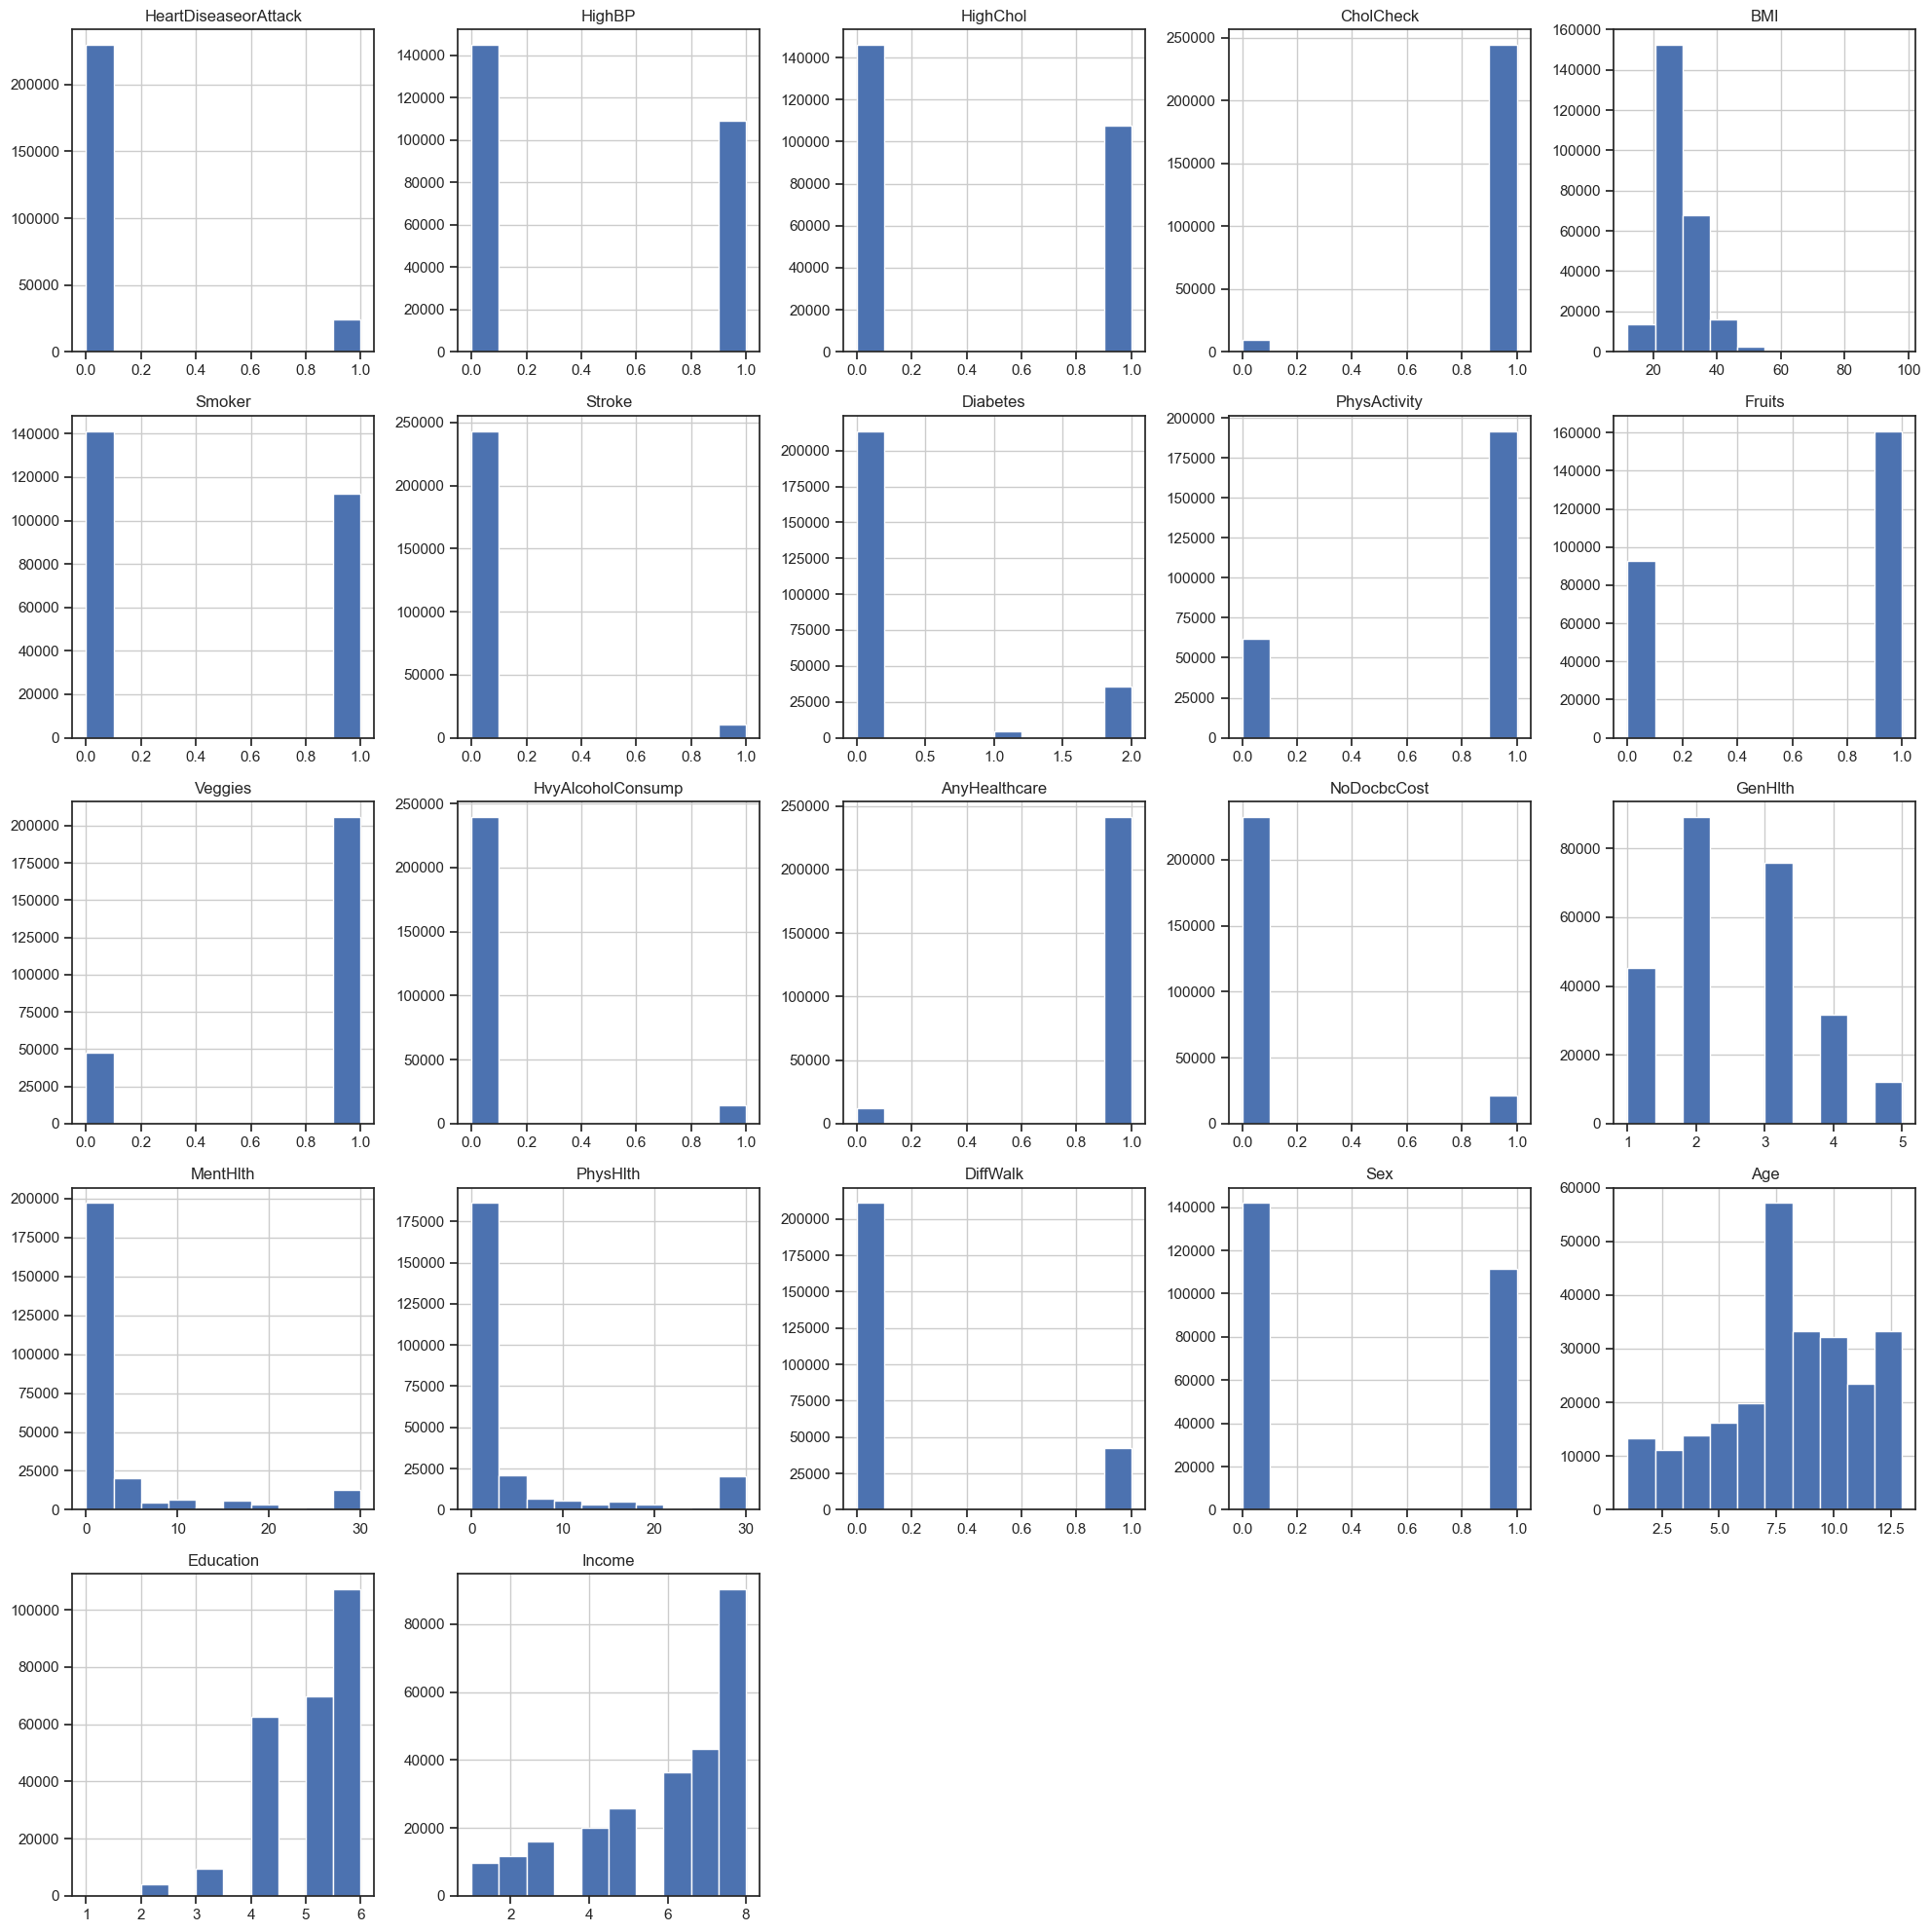

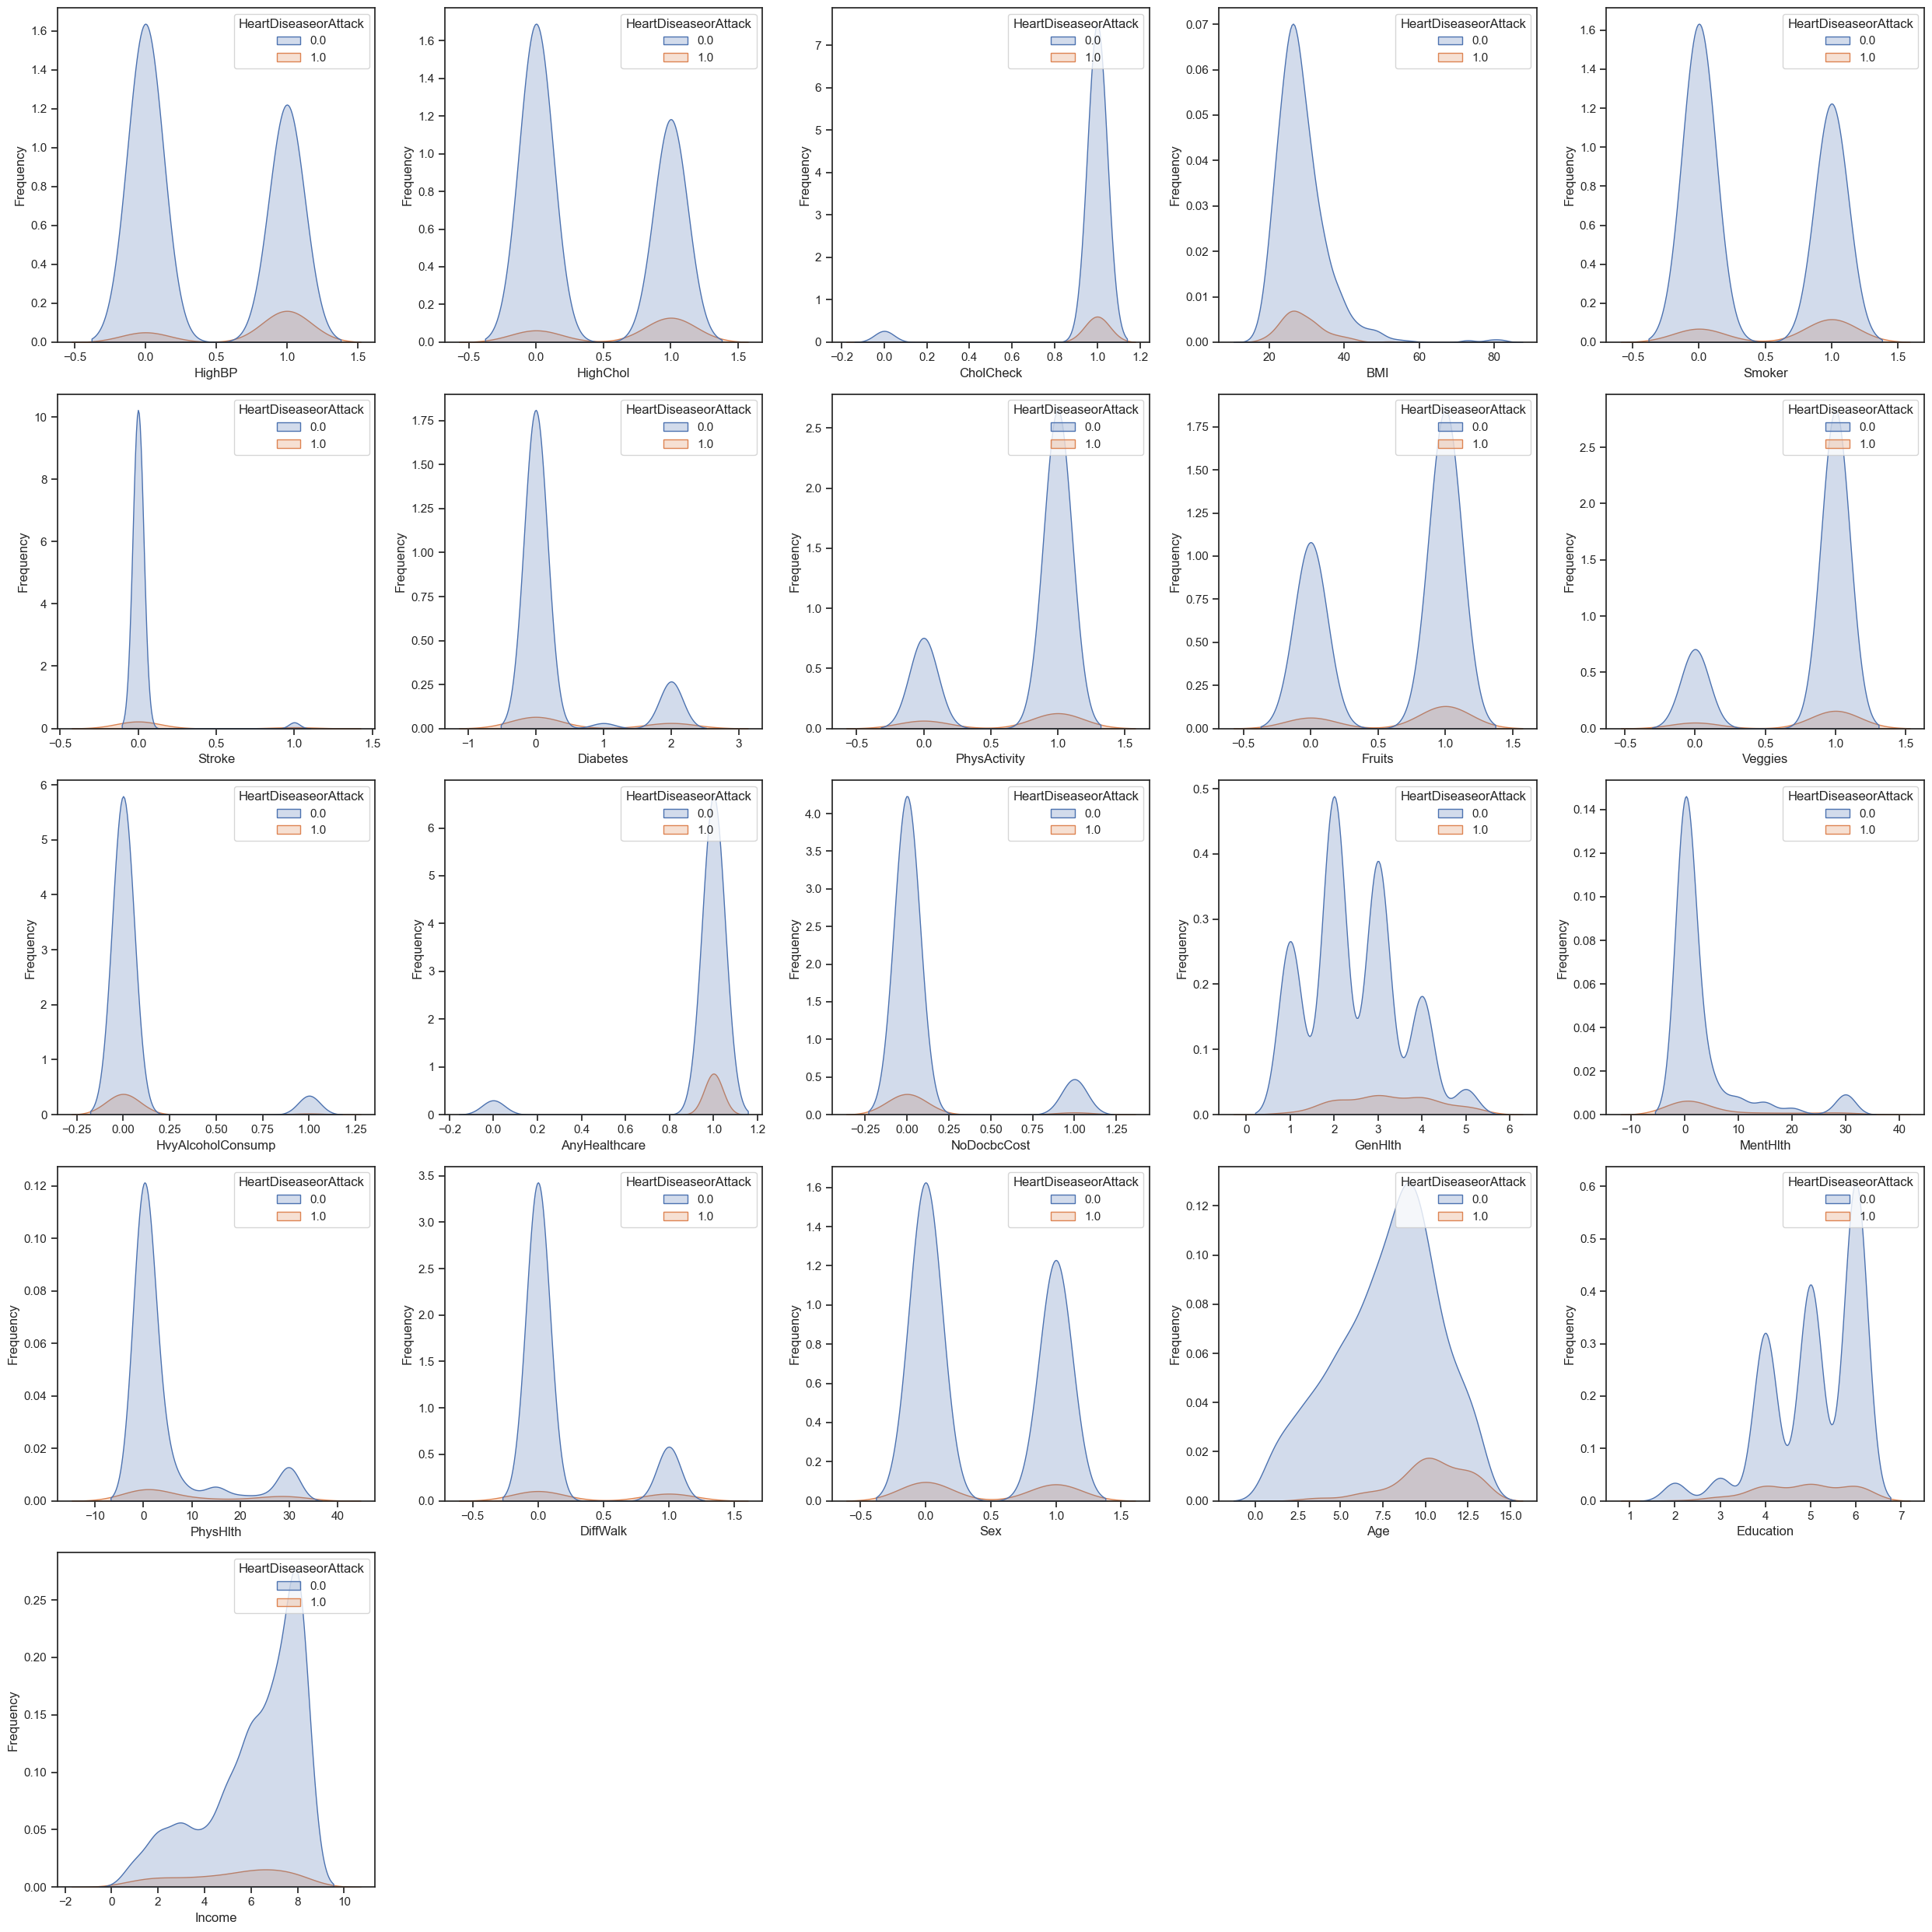

In [6]:
sample_df = df.sample(1_000)

df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

###########

# Determine the number of columns in the pairplot grid
num_cols = 5  # Adjust the number of columns as needed

# Calculate the number of rows needed for the pairplot grid
num_rows = (len(all_features) + num_cols - 1) // num_cols

# Create a single figure and axes for the pairplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Plot each feature against the target variable
for i, feature in enumerate(all_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.kdeplot(data=sample_df, x=feature, hue=target_column, fill=True, ax=ax)
    ax.set_ylabel("Frequency")

# Hide empty subplots
for i in range(len(all_features), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Show the combined pairplot image
plt.tight_layout()
plt.show()

### 3.3 Pattern identification

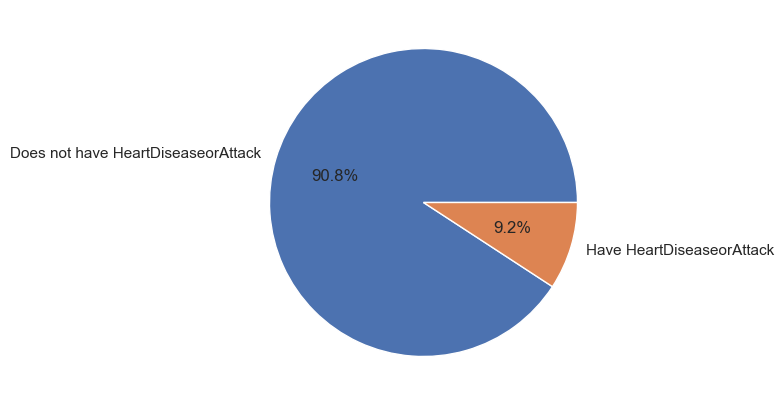

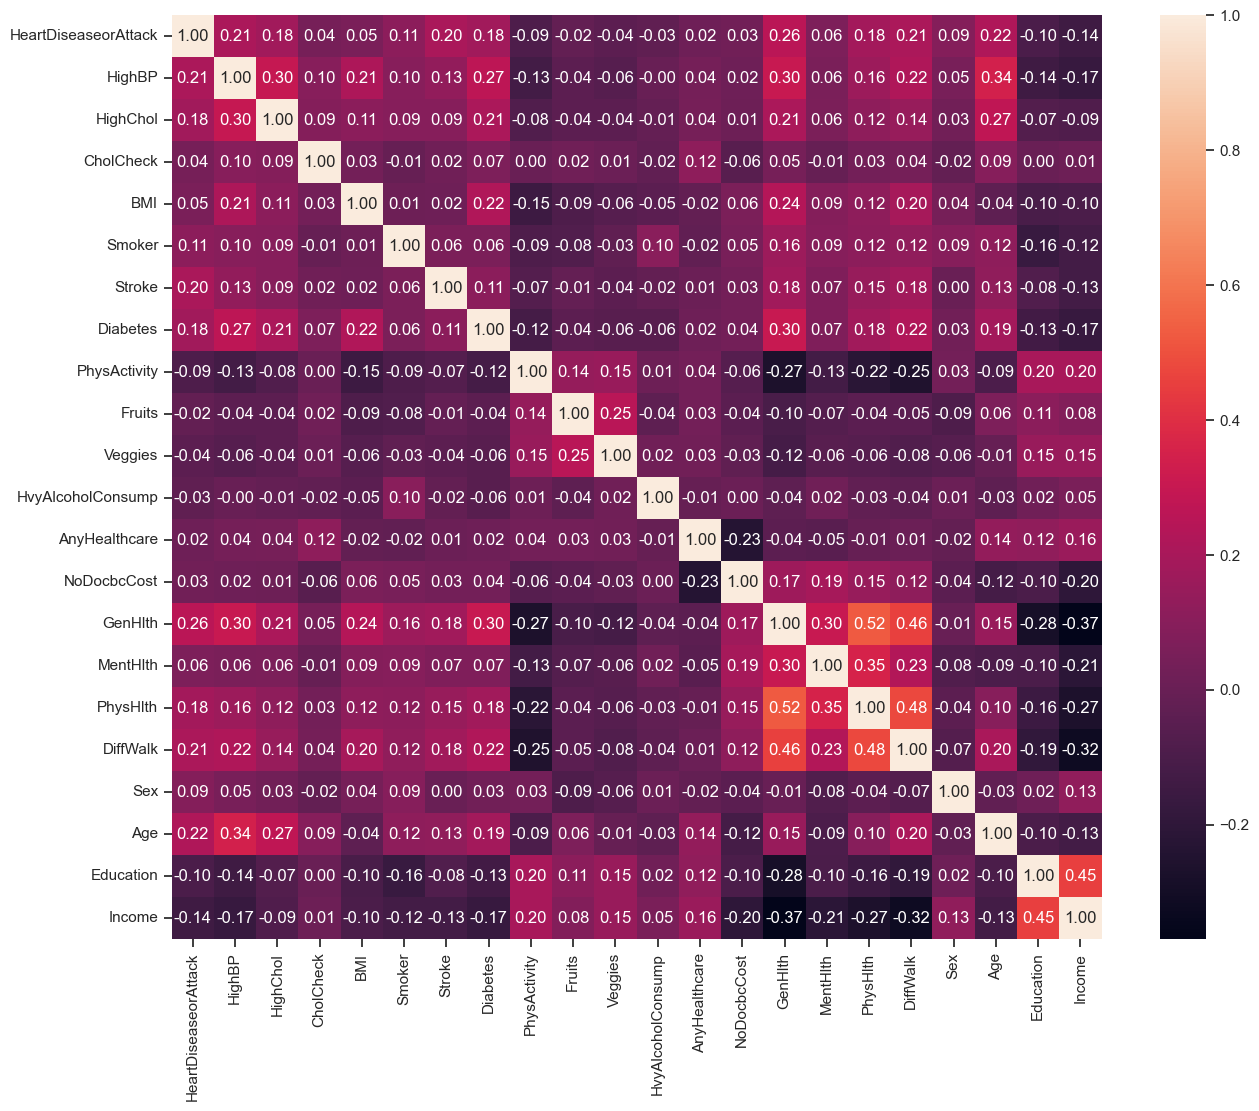

In [7]:
# plotting data on chart
# plt.pie(sample_df[target_column].value_counts(), )

fig, ax = plt.subplots(figsize=(5, 5))

_ = sample_df[target_column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax, labels=["Does not have HeartDiseaseorAttack", "Have HeartDiseaseorAttack"])
_ = ax.yaxis.set_visible(False)
# displaying chart
plt.show()

# Correlation matrix
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Step 4: Data preprocessing
TODO: Handle missing values, encode categorical variables, perform feature scaling, etc.

In [8]:
df.drop_duplicates(keep='first', inplace=True)
# No missing value so we're good

## Step 6: Split the dataset into train and test sets

In [9]:
# Sample the dataset
logger.info("Sampling the dataset...")
sample_df = df.sample(frac=0.1, random_state=42)

# Split data into train and test sets
logger.info("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[target_column], test_size=0.2, random_state=42)

INFO:__main__:Sampling the dataset...
INFO:__main__:Splitting data into train and test sets...


## Step 7: Feature scaling

## Step 8: Model training

In [10]:
from joblib import Memory

# Create a memory object to cache the results
memory = Memory(location='cache', verbose=0)

# Define a function to create a scorer for PR AUC
def pr_auc_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

# Wrap the grid search function with the memory object
@memory.cache
def grid_search_fit(pipeline, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(pr_auc_scorer, needs_proba=True), verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Define resampling techniques
logger.info("Defining resampling techniques...")
resampling_techniques = {
    'smote': SMOTE(random_state=42),
    'adasyn': ADASYN(random_state=42),
    'borderline_smote': BorderlineSMOTE(random_state=42),
    'svm_smote': SVMSMOTE(random_state=42),
    'random_under_sampler': RandomUnderSampler(random_state=42),
    'tomek_links': TomekLinks(),
    'edited_nearest_neighbours': EditedNearestNeighbours()
}

# Define classifiers
logger.info("Defining classifiers...")
classifiers = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'gb': GradientBoostingClassifier(random_state=42)
}

# Define pipelines for different strategies
logger.info("Creating pipelines...")
pipelines = {}
for resampling_name, resampling_technique in resampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        pipe_name = f"{resampling_name}_{classifier_name}"
        scaler = MinMaxScaler()
        pipelines[pipe_name] = ImbPipeline([
            ('scaler', scaler),
            ('resampling', resampling_technique),
            ('classifier', classifier)
        ])

# Define parameter grids for grid search
logger.info("Defining parameter grids for grid search...")
param_grids = {
    'rf': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    },
    'gb': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

# Perform grid search and evaluate models
logger.info("Performing grid search and evaluating models...")
results = {}
pipeline_total = len(pipelines)
start = time.time()
for idx, (name, pipeline) in enumerate(pipelines.items()):
    logger.info(f"Training {name} {100*idx/pipeline_total:.1f}%...")
    classifier_name = name.split('_')[-1]
    param_grid = param_grids[classifier_name]
    # cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(pr_auc_scorer, response_method="predict_proba"), verbose=3, n_jobs=-1)
    # grid_search.fit(X_train, y_train)
    
    # Call the grid search function, which will check the cache before running
    grid_search = grid_search_fit(pipeline, param_grid, X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    results[name] = {
        'best_model': best_model,
        'classification_report': report
    }

elapsed_time = time.time() - start

# Convert elapsed time to hours, minutes, and seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Print elapsed time in a nice format
print(f"Total Training Time: {int(hours):02d} hours, {int(minutes):02d} minutes, {seconds:.2f} seconds")

# Print results
logger.info("Printing results...")
for name, result in results.items():
    print(f"\n{name.upper()} MODEL:")
    print("Best Model Parameters:", result['best_model'].get_params())
    print("Classification Report:")
    print(result['classification_report'])


INFO:__main__:Defining resampling techniques...
INFO:__main__:Defining classifiers...
INFO:__main__:Creating pipelines...
INFO:__main__:Defining parameter grids for grid search...
INFO:__main__:Performing grid search and evaluating models...
INFO:__main__:Training smote_rf 0.0%...
INFO:__main__:Training smote_gb 7.1%...
INFO:__main__:Training adasyn_rf 14.3%...
INFO:__main__:Training adasyn_gb 21.4%...
INFO:__main__:Training borderline_smote_rf 28.6%...
INFO:__main__:Training borderline_smote_gb 35.7%...
INFO:__main__:Training svm_smote_rf 42.9%...
INFO:__main__:Training svm_smote_gb 50.0%...
INFO:__main__:Training random_under_sampler_rf 57.1%...
INFO:__main__:Training random_under_sampler_gb 64.3%...
INFO:__main__:Training tomek_links_rf 71.4%...
INFO:__main__:Training tomek_links_gb 78.6%...
INFO:__main__:Training edited_nearest_neighbours_rf 85.7%...
INFO:__main__:Training edited_nearest_neighbours_gb 92.9%...
INFO:__main__:Printing results...


Total Training Time: 00 hours, 00 minutes, 2.61 seconds

SMOTE_RF MODEL:
Best Model Parameters: {'memory': None, 'steps': [('scaler', MinMaxScaler()), ('resampling', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42))], 'verbose': False, 'scaler': MinMaxScaler(), 'resampling': SMOTE(random_state=42), 'classifier': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42), 'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'resampling__k_neighbors': 5, 'resampling__n_jobs': None, 'resampling__random_state': 42, 'resampling__sampling_strategy': 'auto', 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifie

{'smote_rf': {'best_model': Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, random_state=42))]), 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.95      0.87      0.91      4139\n         1.0       0.32      0.57      0.41       457\n\n    accuracy                           0.84      4596\n   macro avg       0.63      0.72      0.66      4596\nweighted avg       0.89      0.84      0.86      4596\n'}, 'smote_gb': {'best_model': Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', SMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))]), 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.93      0

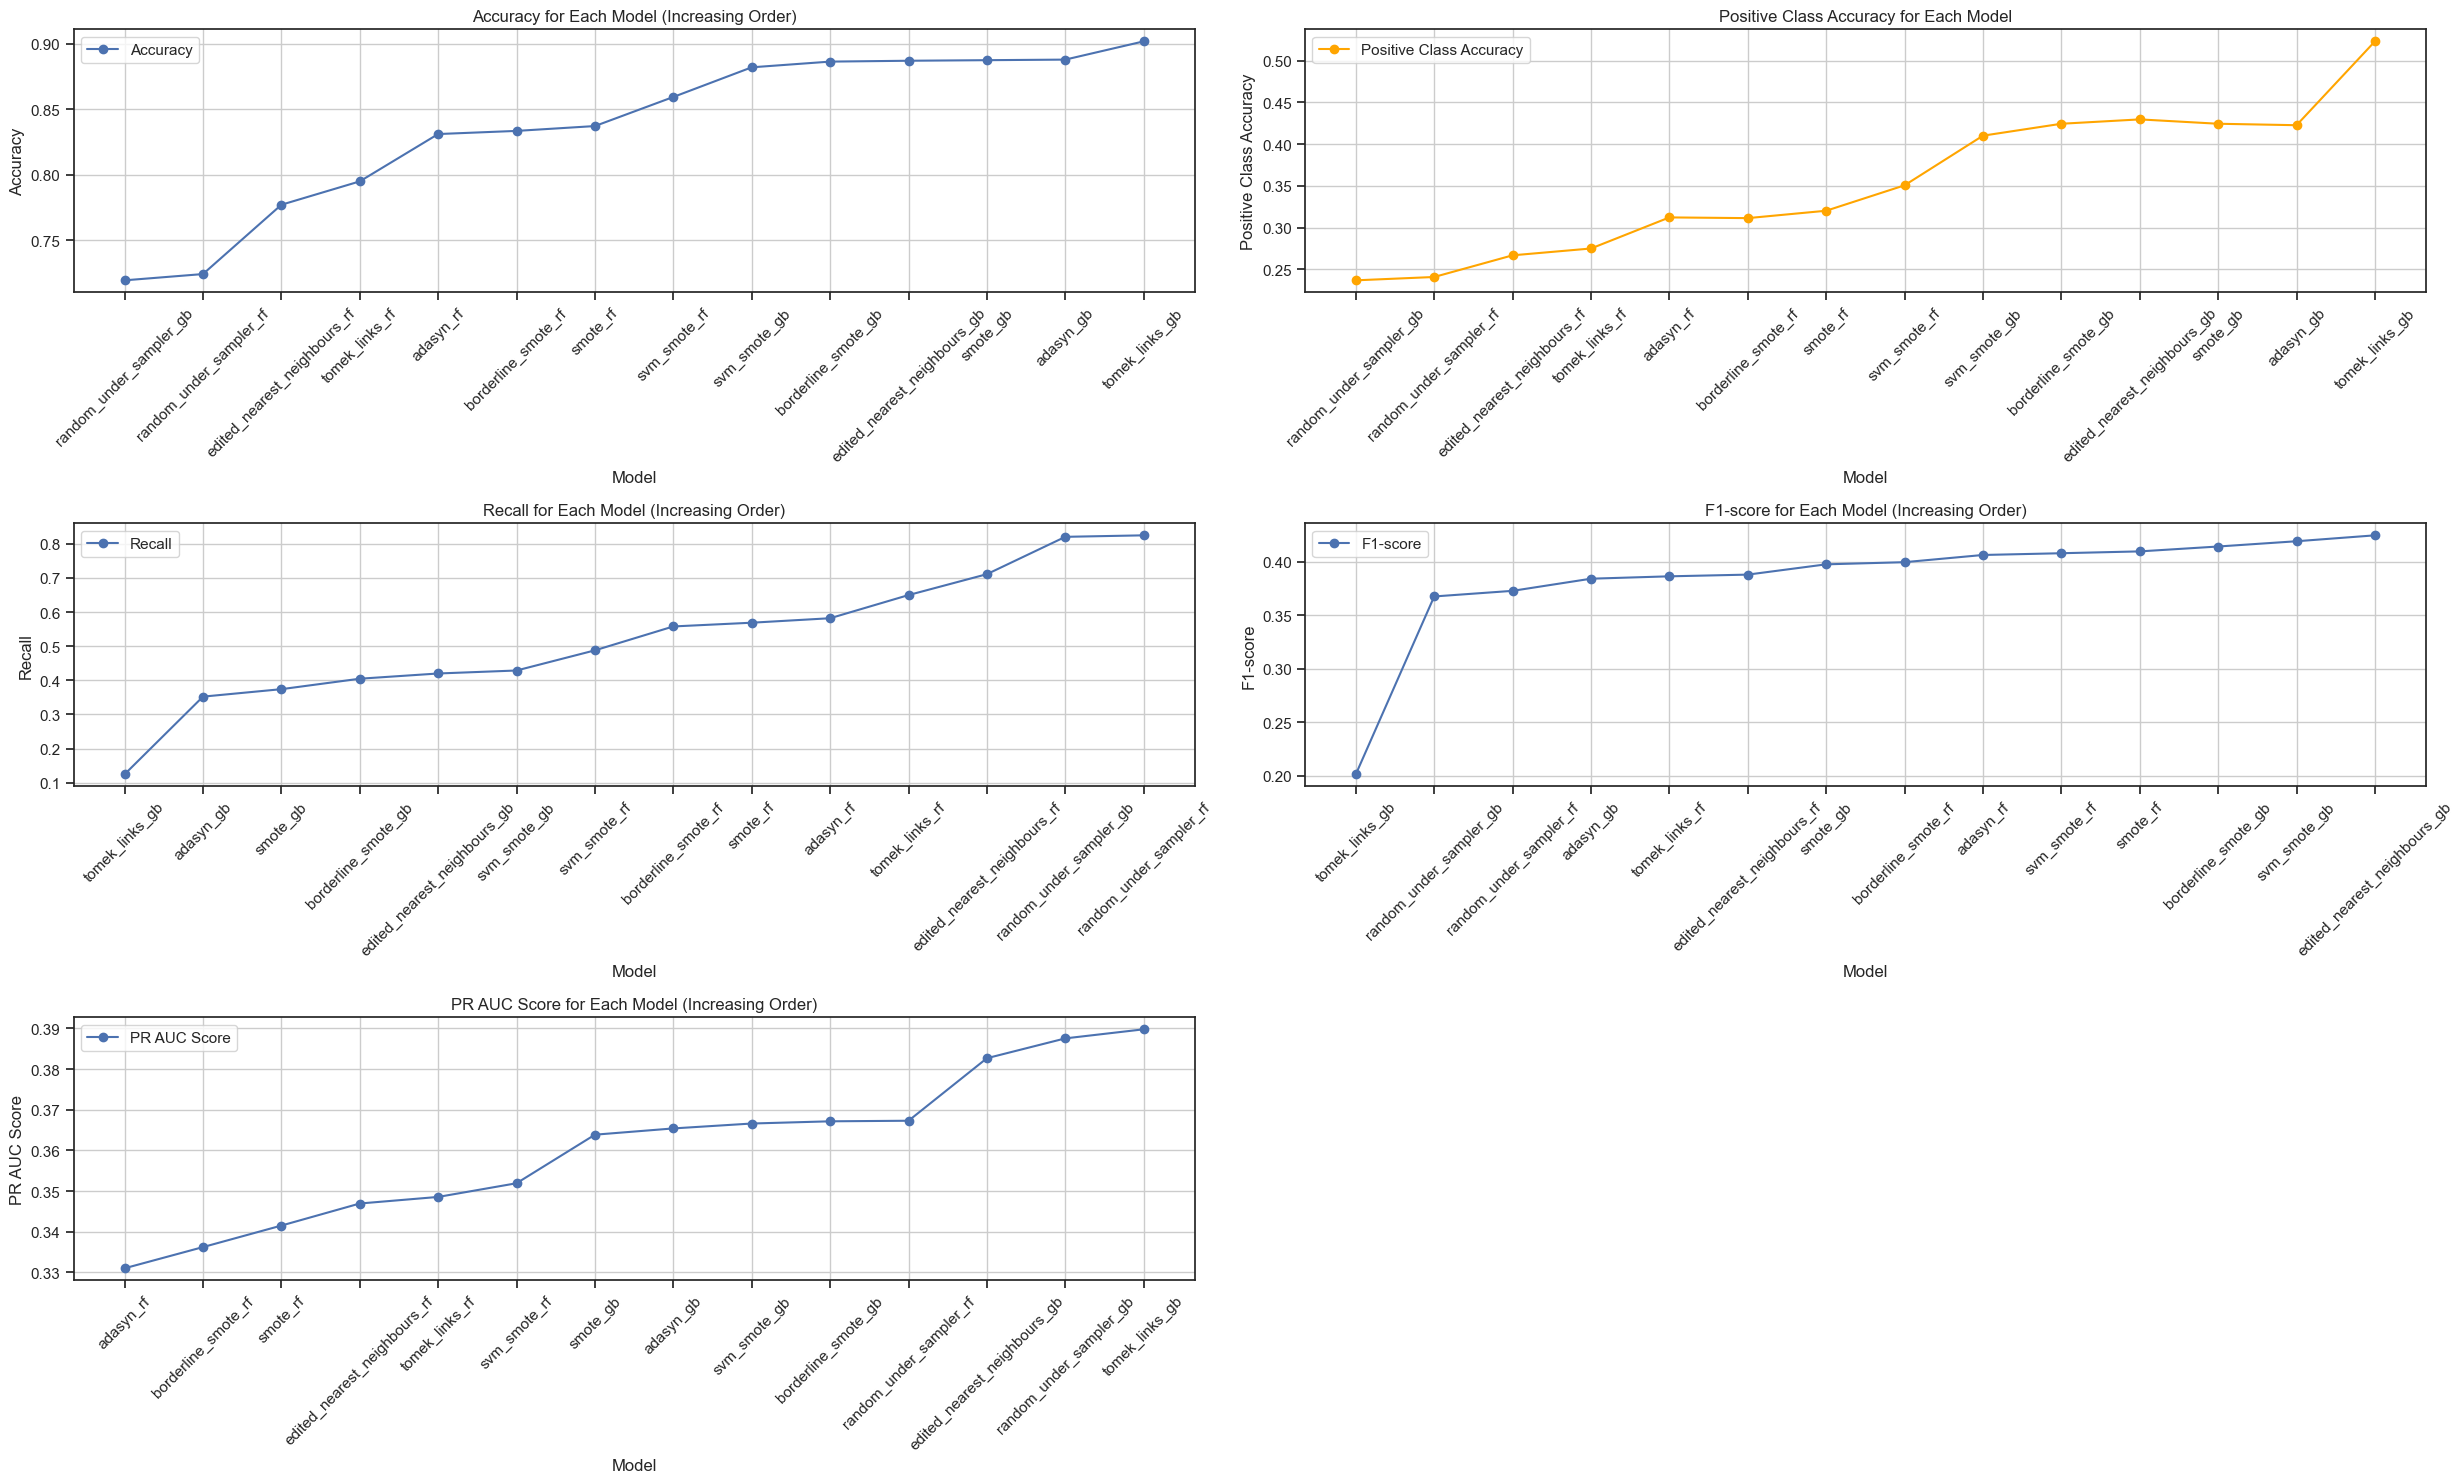

In [11]:
# Collect scores for each model
model_scores = []
for name, result in results.items():
    pr_auc = average_precision_score(y_test, result['best_model'].predict_proba(X_test)[:, 1])
    report_dict = classification_report(y_test, result['best_model'].predict(X_test), output_dict=True)
    accuracy = report_dict['accuracy']
    recall = report_dict['1.0']['recall'] if '1.0' in report_dict else 0  # Recall for positive class
    f1_score = report_dict['1.0']['f1-score'] if '1.0' in report_dict else 0  # F1-score for positive class
    
    # Calculate accuracy for positive class
    positive_accuracy = report_dict['1.0']['precision'] if '1.0' in report_dict else 0
    
    model_scores.append((name, accuracy, recall, f1_score, pr_auc, positive_accuracy))
print(results)
# Sort the models based on each metric score in increasing order
model_scores_accuracy = sorted(model_scores, key=lambda x: x[1])
model_scores_recall = sorted(model_scores, key=lambda x: x[2])
model_scores_f1_score = sorted(model_scores, key=lambda x: x[3])
model_scores_pr_auc = sorted(model_scores, key=lambda x: x[4])

# Extract model names and corresponding scores for plotting
model_names_accuracy = [name for name, _, _, _, _, _ in model_scores_accuracy]
model_names_recall = [name for name, _, _, _, _, _ in model_scores_recall]
model_names_f1_score = [name for name, _, _, _, _, _ in model_scores_f1_score]
model_names_pr_auc = [name for name, _, _, _, _, _ in model_scores_pr_auc]

accuracy_scores = [accuracy for _, accuracy, _, _, _, _ in model_scores_accuracy]
recall_scores = [recall for _, _, recall, _, _, _ in model_scores_recall]
f1_scores = [f1_score for _, _, _, f1_score, _, _ in model_scores_f1_score]
pr_auc_scores = [pr_auc for _, _, _, _, pr_auc, _ in model_scores_pr_auc]
positive_accuracy_scores = [positive_accuracy for _, _, _, _, _, positive_accuracy in model_scores_accuracy]

# Plot scores
plt.figure(figsize=(25, 15))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(model_names_accuracy, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Positive Class Accuracy
plt.subplot(3, 2, 2)
plt.plot(model_names_accuracy, positive_accuracy_scores, label='Positive Class Accuracy', marker='o', color='orange')
plt.xlabel('Model')
plt.ylabel('Positive Class Accuracy')
plt.title('Positive Class Accuracy for Each Model')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Recall
plt.subplot(3, 2, 3)
plt.plot(model_names_recall, recall_scores, label='Recall', marker='o')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# F1-score
plt.subplot(3, 2, 4)
plt.plot(model_names_f1_score, f1_scores, label='F1-score', marker='o')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# PR AUC Score
plt.subplot(3, 2, 5)
plt.plot(model_names_pr_auc, pr_auc_scores, label='PR AUC Score', marker='o')
plt.xlabel('Model')
plt.ylabel('PR AUC Score')
plt.title('PR AUC Score for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Step 9: Model evaluation

For our binary classification challenge PR AUC Score is more important

[('tomek_links_gb', 0.9016536118363795, 0.12472647702407003, 0.20141342756183744, 0.38979542375643617, 0.5229357798165137), ('random_under_sampler_gb', 0.7193211488250653, 0.8205689277899344, 0.36764705882352944, 0.3875660210635499, 0.2368919772583702), ('edited_nearest_neighbours_gb', 0.886858137510879, 0.4201312910284464, 0.4247787610619469, 0.3826897617286723, 0.42953020134228187)]


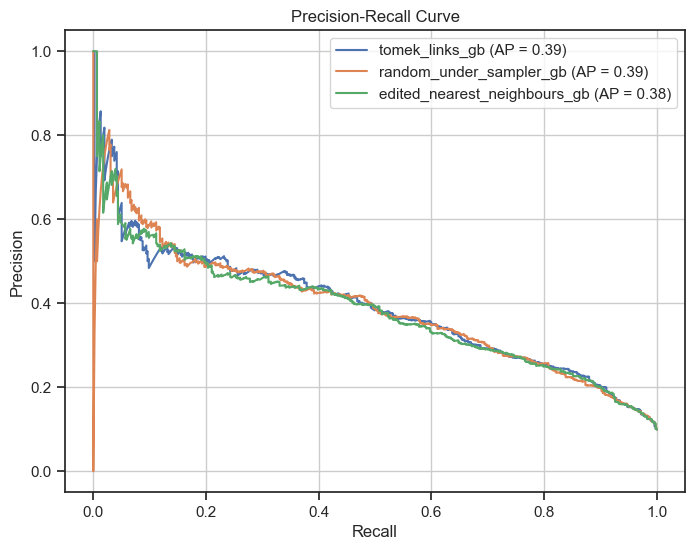

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Assuming model_scores is a list of (model_name, accuracy, recall, f1_score, pr_auc) tuples
top_models = sorted(model_scores, key=lambda x: x[4], reverse=True)[:3]

plt.figure(figsize=(8, 6))
print(top_models)
for model_name, _, _, _, _, _ in top_models:
    # Assuming model_dict contains the trained model objects
    model =  results[model_name]["best_model"]
    
    # Predict probabilities on the test set
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Calculate average precision
    avg_precision = average_precision_score(y_test, y_scores)
    
    # Plot PR curve
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

As seen in this plot, they all have pretty much line. We should then rely on the recall score to base our best model.

In [13]:
best_model_name = None
best_recall_score = 0

for name, result in results.items():
    report_dict = classification_report(y_test, result['best_model'].predict(X_test), output_dict=True)

    recall = report_dict['1.0']['recall']  # Assuming the classification report is a dictionary
    if recall > best_recall_score:
        best_recall_score = recall
        best_model_name = name

print("Best Model based on Recall Score:")
print(f"Model Name: {best_model_name}")
print(f"Recall Score: {best_recall_score}")
print("Classification report:\n", results[best_model_name]["classification_report"])
print(f"Model Parameters: {results[best_model_name]['best_model'].get_params()}")


Best Model based on Recall Score:
Model Name: random_under_sampler_rf
Recall Score: 0.824945295404814
Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      4139
         1.0       0.24      0.82      0.37       457

    accuracy                           0.72      4596
   macro avg       0.61      0.77      0.60      4596
weighted avg       0.90      0.72      0.78      4596

Model Parameters: {'memory': None, 'steps': [('scaler', MinMaxScaler()), ('resampling', RandomUnderSampler(random_state=42)), ('classifier', RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42))], 'verbose': False, 'scaler': MinMaxScaler(), 'resampling': RandomUnderSampler(random_state=42), 'classifier': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42), 'scaler__clip': False, 'scaler__copy': True, 'scaler_

In [14]:
# NOT GOING TO WORK FOR NOW SIMCE USING imblearn :( , will need to find a solution

# # saving model
# import onnx
# from onnx import shape_inference
# from skl2onnx import convert_sklearn

# import numpy as np
# from skl2onnx.common.data_types import FloatTensorType

# # Define initial types based on your input data
# initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]

# # Convert the best model to ONNX format with initial types
# onnx_model = convert_sklearn(best_model, 'best_model', initial_types=initial_types)

# # Infer shapes (optional but recommended)
# onnx_model = shape_inference.infer_shapes(onnx_model)

# # Define the path to save the ONNX model
# onnx_file_path = 'best_model.onnx'

# # Save the ONNX model to a file
# onnx.save_model(onnx_model, onnx_file_path)

# print("ONNX model saved successfully.")

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'imblearn.under_sampling._prototype_selection._edited_nearest_neighbours.EditedNearestNeighbours'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


## Step 10: Confusion matrix

## Step 11: Classification report